In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json

## Mount Google Drive and create paths for directories


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_cancer_path = oj(data_path, "processed", "no_cancer_224")
cancer_path = oj(data_path, "processed", "cancer_224")

### Arguments for training

In [ ]:
import cv2
import numpy as np
from numpy import random
from numpy.random import randint
from matplotlib import pyplot as plt
import math

def find_angle(pos1, pos2, ret_type = 'deg'):
    # Find the angle between two pixel points, pos1 and pos2.
    angle_rads = math.atan2(pos2[1] - pos1[1], pos2[0] - pos1[1])

    if ret_type == 'rads':
        return angle_rads
    elif ret_type == 'deg':
        return math.degrees(angle_rads)                                     # Convert from radians to degrees.


def sample_centre_pts(n, imsize, xlimits=(50,250), ylimits=(50,250)):
    # Function to generate random sample of points for the centres of the elliptical masks.
    pts = np.empty((n,2))                                                   # Empty array to hold the final points

    count=0
    while count < n:
        sample = randint(0, imsize[0], (n,2))[0]                            # Assumes im_size is symmetric

        # Check the point is in the valid region.
        is_valid = (sample[0] < xlimits[0]) | (sample[0] > xlimits[1]) |     \
                (sample[1] < ylimits[0]) | (sample[1] > ylimits[1])

        if is_valid:                                                        # Only take the point if it's within the valid region.
            pts[count] = sample
            count += 1

    return pts

def generate_ellipse_mask(imsize, mask_size, seed=None):
    im_centre = (int(imsize[0] / 2), int(imsize[1] / 2))
    x_bounds = (int(0.1 * imsize[0]), int(imsize[0] - 0.1 * imsize[0]))  # Bounds for the valid region of mask centres.
    y_bounds = (int(0.1 * imsize[1]), int(imsize[1] - 0.1 * imsize[1]))

    if seed is not None:
        random.seed(seed)  # Set seed for repeatability

    n = 1 + random.binomial(1, 0.3)  # The number of masks per image either 1 (70% of the time) or 2 (30% of the time)
    centre_pts = sample_centre_pts(n, imsize, x_bounds, y_bounds)  # Get a random sample for the mask centres.

    startAngle = 0.0
    endAngle = 360.0  # Draw full ellipses (although part may fall outside the image)

    mask = np.zeros((imsize[0], imsize[1], 3), np.float32)  # Create blank canvas for the mask with 3 channels.

    for pt in centre_pts:
        size = abs(int(random.normal(mask_size, mask_size / 5.0)))  # Randomness introduced in the mask size.
        ratio = 2 * random.random(1) + 1  # Ratio between length and width. Sample from Unif(1,3).

        centrex = int(pt[0])
        centrey = int(pt[1])

        angle = find_angle(im_centre, (centrex, centrey))  # Get the angle between the centre of the image and the mask centre.
        angle = int(angle + random.normal(0.0, 5.0))  # Base the angle of rotation on the above angle.

        mask = cv2.ellipse(mask, (centrex, centrey), (size, int(size * ratio)),
                           angle, startAngle, endAngle,
                           color=(1, 1, 1), thickness=-1)  # Insert an ellipse with the parameters defined above.

    mask = np.minimum(mask, 1.0)  # This may be redundant.

    return mask



#test_mask = generate_ellipse_mask(imsize = (224,224), mask_size = 40)
#from matplotlib import pyplot as plt
#plt.imshow(test_mask[0][0], cmap='Greys_r')
#plt.show()

In [ ]:
#test_mask = generate_ellipse_mask(imsize = (224,224), mask_size = 40)
#from matplotlib import pyplot as plt
#plt.imshow(test_mask[0][0], cmap='Greys_r')
#plt.show()

In [ ]:
# Paths
source_folder = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/data/processed/cancer_224'
destination_folder = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/patched_224/'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate over all images in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        # Load the test image
        test_image_path = os.path.join(source_folder, filename)
        test_image = cv2.imread(test_image_path)
        test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Generate the mask
        mask_size = 40  # Set the desired mask size
        mask = generate_ellipse_mask(imsize=test_image.shape[:2], mask_size=mask_size)

        # Set the color for the color-patched regions
        alpha = 0.30 # Set the alpha value for opacity
        color = np.random.randint(0, 256, size=3)  # Random color
        color_with_alpha = np.append(color, alpha)  # Append alpha value to color array

        # Apply the mask to the test image
        color_patched_image = np.where(mask > 0, color, test_image)

        # Save the color-patched image to the destination folder
        destination_path = os.path.join(destination_folder, filename)
        color_patched_image = cv2.cvtColor(color_patched_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
        cv2.imwrite(destination_path, color_patched_image)

<ipython-input-146-1de58069e218>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask = cv2.ellipse(mask, (centrex, centrey), (size, int(size * ratio)),


<ipython-input-146-1de58069e218>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask = cv2.ellipse(mask, (centrex, centrey), (size, int(size * ratio)),


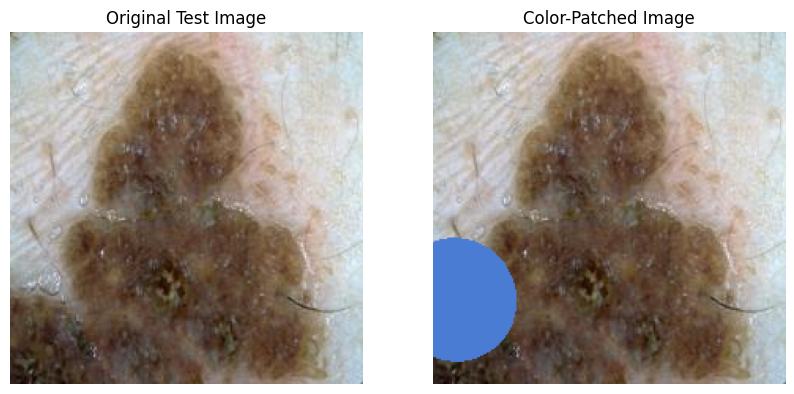

In [ ]:
# Load the test image from drive
test_image_path = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/raw_224/ISIC_0011603.jpg'
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV reads in BGR by default)

# Generate the mask
mask_size = 40  # Set the desired mask size
mask = generate_ellipse_mask(imsize=(224, 224), mask_size=mask_size)

# Set the color for the color-patched regions
alpha = 50 # Set the alpha value for opacity
#color = np.array([255, 0, 0])  # Red color (in RGB format)
color = np.random.randint(0, 256, size=3)
color_with_alpha = np.append(color, alpha)  # Append alpha value to color array


# Apply the mask to the test image
color_patched_image = np.where(mask > 0, color, test_image)

# Display the original test image and the color-patched image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(color_patched_image)
plt.title('Color-Patched Image')
plt.axis('off')

plt.show()


In [ ]:
import numpy as np

# Generate a random RGB color
color = np.random.randint(0, 256, size=(1, 1, 3))  # Shape: (1, 1, 3)

# Create an alpha channel with the same size as the image, fully transparent
alpha_channel = np.zeros((224, 224, 1), dtype=np.uint8)  # Fully transparent

# Add a fully transparent alpha channel to the original test image
test_image_with_alpha = np.concatenate((test_image, alpha_channel), axis=2)

# Repeat the color array to match the size of the image
color_repeated = np.repeat(np.repeat(color, 224, axis=0), 224, axis=1)

# Combine the color and alpha channels
color_with_alpha = np.concatenate((color_repeated, alpha_channel), axis=2)

# Add an extra channel to the mask (if necessary)
if mask.ndim == 2:
    mask = np.expand_dims(mask, axis=2)  # Expand dimensions to match color_with_alpha

# Add an alpha channel to the mask
alpha_channel_mask = np.full_like(mask, 255, 4)  # Fully opaque alpha channel
#alpha_channel_mask = np.full_like(mask, 255, dtype=np.uint8)  # Fully opaque alpha channel
mask_with_alpha = np.concatenate((mask, alpha_channel_mask), axis=2)  # Concatenate mask and alpha channel

# Apply the mask to the test image
color_patched_image = np.where(mask_with_alpha > 0, color_with_alpha, test_image_with_alpha)

# Blend the color-patched image with the original image
blended_image = cv2.addWeighted(test_image_with_alpha, 1 - alpha_channel / 255, color_patched_image, alpha_channel / 255, 0)

# Display the original test image and the blended image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blended_image[:, :, :3])  # Remove the alpha channel for display
plt.title('Blended Image')
plt.axis('off')

plt.show()


In [ ]:
# Generate the mask
mask_size = 40  # Set the desired mask size
mask = generate_ellipse_mask(imsize=(224, 224), mask_size=mask_size)

# Print debug information
print("Mask Shape:", mask.shape)
print("Mask Values:", mask)

# Apply the mask to the test image
color_patched_image = test_image.copy()  # Make a copy of the original image
for i in range(mask.shape[1]):  # Iterate over the width of the mask
    for j in range(mask.shape[2]):  # Iterate over the height of the mask
        if mask[0, i, j] > 0:  # Check if the mask value is greater than 0 (indicating part of the ellipse)
            color = [random.randint(0, 255) for _ in range(3)]  # Generate a random RGB color
            color_patched_image[i, j] = color  # Assign the random color to the corresponding pixel in the color-patched image


# Display the original test image and the color-patched image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(color_patched_image)
plt.title('Color-Patched Image')
plt.axis('off')

plt.show()

In [ ]:
# Generate the mask
mask_size = 40  # Set the desired mask size
mask = generate_ellipse_mask(imsize=(224, 224), mask_size=mask_size)

# Display the generated mask
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Generated Mask')
plt.axis('off')
plt.show()

In [ ]:
print("Test Image Shape:", test_image.shape)
print("Generated Mask Shape:", generated_mask.shape)
